# Loading, Cleaning and Aggregating Session Data

## Loading the Data
As a first step we load the session data, received from the municipality of Amsterdam, from Excel and CSV files on Google Drive into a Pandas data frame. Please note that we have initially received data from 2020 until the first quarter of 2023, however for the years 2020 and 2021 the data was unfortunately incomplete which is why we have decided to restrict our data model on a time frame from 01.2022 - 03.2023. In the below code we have defined different file paths as we were running the code seperately for each year due to the high amount of observations per year. Depending on which year to process the other years stay commented out.  

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# defining the file paths on Google Drive
import pandas as pd

file_path_2023 = '/content/drive/My Drive/2023-04-18_CDR_FROM_2023-01_TO_2023-03.xlsx'
df_session_2023 = pd.read_excel(file_path_2023)

# file_path_2022_a = '/content/drive/My Drive/2022-09-08_CDR_FROM_2022-01_TO_2022-06.csv'
# df_session_2022_a = pd.read_csv(file_path_2022_a, sep = ';')

# file_path_2022_b = '/content/drive/My Drive/2023-05-23_CDR_FROM_2022-07_TO_2022-12.csv'
# df_session_2022_b = pd.read_csv(file_path_2022_b, sep = ';')

# file_path_2020 = '/content/drive/My Drive/CDR_Amsterdam_2019_2020.csv'
# df_session_2020 = pd.read_csv(file_path_2020, sep = ";", encoding='ISO-8859-1')

# file_path_2021 = '/content/drive/My Drive/CDR_Amsterdam_2021-jan.csv'
# df_session_2021 = pd.read_csv(file_path_2021, sep = 't')

In [29]:
# change depending on which dataset you are loading and cleaning
df_session = df_session_2023

In [30]:
# print the data frame to get an idea
print(df_session)

                              Transaction_ID    Provider       City  \
0           000C22849C2943A9A805A54FE611D61D       TOTAL  Amsterdam   
1       001bcad2-391a-431f-adbd-f5702ccfbc85  VATTENFALL  Amsterdam   
2           003df9e2b5184ce2803dbf64229a544b  VATTENFALL  Amsterdam   
3       0069312d-2c78-4282-b9b8-f79fdb75b677  VATTENFALL  Amsterdam   
4       006eb90e-adfa-46af-b40a-ed66dc39820b  VATTENFALL  Amsterdam   
...                                      ...         ...        ...   
616703  c821750f-edc1-42af-950d-1b256204a50c  VATTENFALL  Amsterdam   
616704  c86b58e8-8970-44af-8afd-3006fe3b6671  VATTENFALL  Amsterdam   
616705      C8CD82D076D84087B91EE9A12B0CCA6B       TOTAL  Amsterdam   
616706  c8d45c5e-8d6e-44e1-8d0e-063d3a0f2617  VATTENFALL  Amsterdam   
616707      C8F051064E9F48299F4A0D266A1E0C14       TOTAL  Amsterdam   

                             Address District                 SubDistrict  \
0             Spanderswoudstraat 111    Noord            Nieuwendam No

In [31]:
# check the dates in the data frame
earliest_date = df_session['StartConnectionDateTime'].min()
latest_date = df_session['StartConnectionDateTime'].max()

print("Earliest Date:", earliest_date)
print("Latest Date:", latest_date)

Earliest Date: 2023-01-01 00:01:25
Latest Date: 2080-01-12 22:35:47


In [32]:
# Ensure 'Date' column is of datetime type
df_session['StartConnectionDateTime'] = pd.to_datetime(df_session['StartConnectionDateTime'])

## Merging and Enhancing Data
We create another data frame in order to merge the master data about each charger with the session data. This enables us to add the max power capacity (in kWh) for each charger. 

In [33]:
file_path_1 = '/content/drive/My Drive/data_charger.csv'

# create a dataframe from excel
df_chargers = pd.read_csv(file_path_1)

In [34]:
# Remove '_1' or '_2' from the end of the 'charger_ID' column to make sure that 
# both charger_ID / chargepoint_IDs have the same format
df_chargers['charger_ID'] = df_chargers['charger_ID'].str.replace('(_[12])$', '', regex=True)


In [35]:
# add power column from master data of the EV chargers
df_session = df_session.merge(df_chargers[['charger_ID', 'power']], 
                              left_on='ChargePoint_ID', right_on='charger_ID', 
                              how='left')

# drop the redundant 'charger_ID' column after the merge
df_session.drop('charger_ID', axis=1, inplace=True)

As our analysis should eventually happen on zipcode level, we need to map a zipcode to each transaction given in the data frame. We approach this by first creating a data frame that contains the unique latitudes and longitudes given in the charging data. 

In [36]:
# create a new df with unique longitute and latitude
unique_loc = df_session[['Latitude', 'Longitude']].drop_duplicates()

In [37]:
# check data types of latitute and longitude 
unique_loc.dtypes

Latitude     float64
Longitude    float64
dtype: object

In [38]:
# transform data
unique_loc['Latitude'] = unique_loc['Latitude'].str.replace(',', '.').astype('float64')
unique_loc['Longitude'] = unique_loc['Longitude'].str.replace(',', '.').astype('float64')


AttributeError: ignored

With the help of the geopy API we are able to retrieve a zipcode per lat/long combination.

In [39]:
# create function to retrieve zipcode per EV charger
import geopy
from geopy.geocoders import Nominatim

def get_zipcode(latitude, longitude, timeout=10):
    geolocator = Nominatim(user_agent="myGeocoder", timeout=timeout)
    location = geolocator.reverse((latitude, longitude))
    if location is not None:
        return location.raw['address'].get('postcode')
    else:
        return None

In [ ]:
# apply function to retrieve zipcode for unique_loc 
for index, row in unique_loc.iterrows():
    latitude = row['Latitude']
    longitude = row['Longitude']
    zipcode = get_zipcode(latitude, longitude)
    if zipcode is not None:
        unique_loc.at[index, 'zipcode'] = zipcode

In [ ]:
# print df to get an idea
unique_loc

In [ ]:
# transform data type of lat/long in the df_session data frame in order to match the 
# attributes in the unique_loc data frame
df_session['Latitude'] = df_session['Latitude'].str.replace(',', '.').astype('float64')
df_session['Longitude'] = df_session['Longitude'].str.replace(',', '.').astype('float64')


In [ ]:
# merge zipcode to df_sesion
df_session = df_session.merge(unique_loc, on=['Latitude', 'Longitude'], how='left')


In [ ]:
# check zipcode column in df_session
df_session['zipcode']

In [40]:
# replace "," with "." in kWh and ConnectionTimeHours
df_session['kWh'] = df_session['kWh'].str.replace(',','.')
df_session['ConnectionTimeHours'] = df_session['ConnectionTimeHours'].str.replace(',','.')

AttributeError: ignored

In [41]:
# check transformation
df_session['kWh']

0         13.924
1         14.530
2         30.120
3          7.111
4          4.270
           ...  
616703     6.230
616704     3.360
616705    29.162
616706     1.640
616707    31.010
Name: kWh, Length: 616708, dtype: float64

## Data Transformation and Cleaning

In [ ]:
# make sure that kwh and power are numeric
df_session['kWh'] = pd.to_numeric(df_session['kWh'], errors='coerce')
df_session['power'] = pd.to_numeric(df_session['power'], errors='coerce')

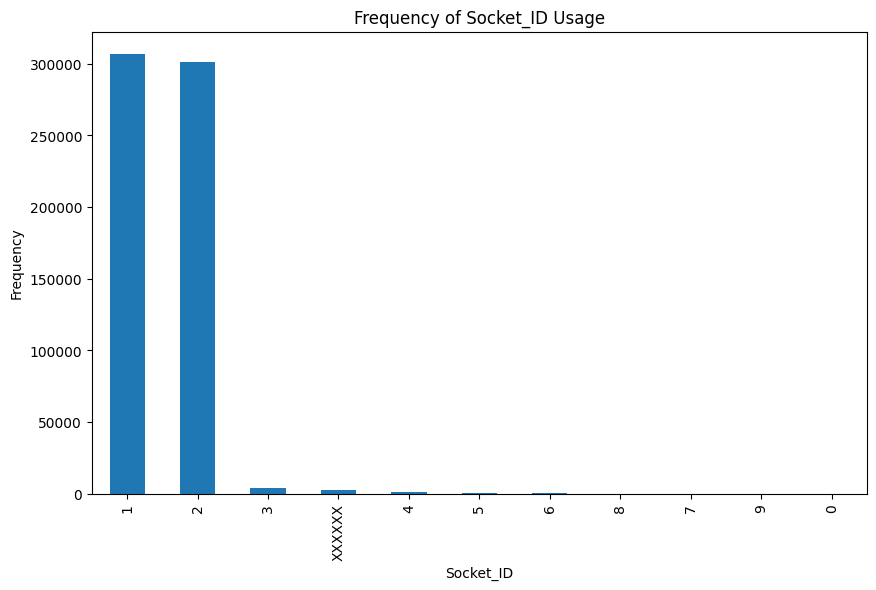

In [42]:
import matplotlib.pyplot as plt

# count the occurrences of each unique Socket_ID
socket_id_counts = df_session['Socket_ID'].value_counts()

# plot the frequency of each Socket_ID in a bar chart
plt.figure(figsize=(10, 6))
socket_id_counts.plot(kind='bar')
plt.xlabel('Socket_ID')
plt.ylabel('Frequency')
plt.title('Frequency of Socket_ID Usage')
plt.show()

We can see that most of the time Socket_IDs "1" and "2" are used. To our information, other Socket_IDs does not necessarily mean that a charger has more than two sockets but rather that different connection methods are used. If we want to see the amount of sockets, we need to look at the count of Socket_IDs per charger. This will be done in a later stage. 

In [43]:
# create new column that combines ChargePoint_ID and Socket_ID
df_session['ChargeSocket_ID'] = df_session['ChargePoint_ID'].astype(str) + '_' + df_session['Socket_ID'].astype(str)

To our information, provided by the city of Amsterdam, we should include the invalid observations from our data frame. 

In [44]:
# count rows
print(df_session.count())

# only keep rows where IsValid is true
df_session = df_session[df_session['IsValid'] == True]

# count rows
print(df_session.count())

Transaction_ID             616708
Provider                   616708
City                       616708
Address                    616708
District                   616708
SubDistrict                616708
SubSubDistrict             616708
SubSubSubDistrict          616708
Latitude                   616708
Longitude                  616708
ChargePoint_ID             616708
Socket_ID                  616708
IsFastCharger              616708
IsAppPayment               616708
StartConnectionDateTime    616708
EndConnectionDateTime      616708
ConnectionTimeHours        616708
kWh                        616708
LoadDateTime               616708
IsValid                    616708
Remark_skey                616708
RemarkText                 616708
power                      483005
ChargeSocket_ID            616708
dtype: int64
Transaction_ID             592267
Provider                   592267
City                       592267
Address                    592267
District                   592267
S

In [45]:
# replace nan with standard charger of 22kwh as this is the standard according 
# to employee from city of Amsterdam
df_session['power'] = df_session['power'].fillna(22.08)

# count rows
print(df_session.count())

Transaction_ID             592267
Provider                   592267
City                       592267
Address                    592267
District                   592267
SubDistrict                592267
SubSubDistrict             592267
SubSubSubDistrict          592267
Latitude                   592267
Longitude                  592267
ChargePoint_ID             592267
Socket_ID                  592267
IsFastCharger              592267
IsAppPayment               592267
StartConnectionDateTime    592267
EndConnectionDateTime      592267
ConnectionTimeHours        592267
kWh                        592267
LoadDateTime               592267
IsValid                    592267
Remark_skey                592267
RemarkText                 592267
power                      592267
ChargeSocket_ID            592267
dtype: int64


In [46]:
# count unique charger_socket_IDs and group per charger_ID and add it to 
# df_session_detail without using the df_session_detail_group
df_session = df_session.merge(df_session.groupby(['ChargePoint_ID']).agg({
    'ChargeSocket_ID': 'nunique'}).reset_index(), on='ChargePoint_ID', how='left')

df_session = df_session.rename(columns={'ChargeSocket_ID_y': 'ChargeSocket_ID_count'})
df_session = df_session.rename(columns={'ChargeSocket_ID_x': 'ChargeSocket_ID'})

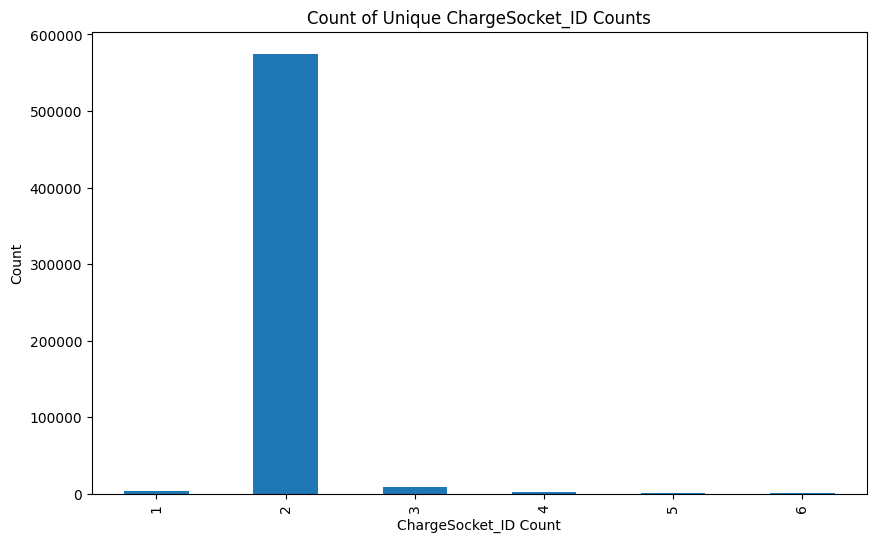

In [47]:
import matplotlib.pyplot as plt

# Group by 'ChargeSocket_ID_count' and count the occurrences
grouped_counts = df_session.groupby('ChargeSocket_ID_count').size()

# Plot the count of unique ChargeSocket_ID counts
plt.figure(figsize=(10, 6))
grouped_counts.plot(kind='bar')
plt.xlabel('ChargeSocket_ID Count')
plt.ylabel('Count')
plt.title('Count of Unique ChargeSocket_ID Counts')
plt.show()

In the EV charger master data we have information about the max capacity which applies to the power a charger can provide. However, the session data gives us information about the usage by sockets. According to our contact person, all the chargers have at most 2 sockets. The assumption can be made that the power therefore can be divided by two, even though in reality this depends on further factors like the car type. As we do not have any information on that, we proceed with the assumption that if the amount of unique socket IDs per charger is 2 or more we can divide the power by the count of socket_IDs per charger. As a side node, we have some (very rare) observations with a charger having more than 2 different transactions at the same time. We assume that there are little specific chargers that indeed then can have more than 2 sockets (derived from the data). 

In [ ]:
# copy the original 'power' column to a new column called 'power_charger'
df_session['power_charger'] = df_session['power']

# if the number of unique charger_socket_IDs is 2 or more, divide the 'power_charger' column 
# by the amount of sockets and store the result in a new column called 'power'
df_session['power'] = df_session['power'] / df_session['ChargeSocket_ID_count']


In the data in can be discovered according to the time 
and kWh information that some EV holders leave their vehicle at the charging station for multiple ours or days even though the car is fully charged after a few hours or even only minutes. In order to capture the time of effectively charging (in hours), we divide the amount of kWhs used by the max capacity of the charger ("power").  

In [ ]:
# calculate effective charging (in hrs) by dividing kwh by max capacity
df_session['effective_charging_hrs'] = df_session['kWh']/df_session['power']

Some of the transaction have a timespan over multiple days. In order to caption all the information we need to split those tranactions into separate rows depending on how long the session was. This is essential as our goal is to aggregate on the daily level.

In [ ]:
from datetime import timedelta

df_session['StartConnectionDateTime'] = pd.to_datetime(df_session['StartConnectionDateTime'], format='%Y-%m-%dT%H:%M:%S')
df_session['EndConnectionDateTime'] = pd.to_datetime(df_session['EndConnectionDateTime'], format='%Y-%m-%dT%H:%M:%S')


# Create a list to store the processed rows
new_rows = []

for _, row in df_session.iterrows():
    start_date = row['StartConnectionDateTime'].date()
    end_date = row['EndConnectionDateTime'].date()
    total_hours = row['ConnectionTimeHours']
    total_effective_charging = row['effective_charging_hrs']

    date_range = pd.date_range(start_date, end_date, freq='D')
    for i, date in enumerate(date_range):
        new_row = row.copy()
        new_row['Date'] = date

        if i == 0:
            new_row['StartConnectionDateTime'] = row['StartConnectionDateTime']
            if len(date_range) > 1:
                new_row['EndConnectionDateTime'] = date.replace(hour=23, minute=59, second=59)
                new_row['effective_charging'] = min(total_effective_charging, 24)
                total_effective_charging -= new_row['effective_charging_hrs']
            else:
                new_row['EndConnectionDateTime'] = row['EndConnectionDateTime']
                new_row['effective_charging'] = total_effective_charging
        elif i == len(date_range) - 1:
            new_row['StartConnectionDateTime'] = date.replace(hour=0, minute=0)
            new_row['EndConnectionDateTime'] = row['EndConnectionDateTime']
            new_row['effective_charging_hrs'] = total_effective_charging
        else:
            new_row['StartConnectionDateTime'] = date.replace(hour=0, minute=0)
            new_row['EndConnectionDateTime'] = date.replace(hour=23, minute=59, second = 59)
            new_row['effective_charging_hrs'] = 0

        new_rows.append(new_row.to_dict())

# Create a new DataFrame with the updated rows
df_session_updated = pd.DataFrame(new_rows)




So far, we did not distribute the kWh usage over the transactions (for multi-day-charging). In the next step this is done by the help of the effective_charging column that has been created previously. With the help of the recalculated start and end times of the sessions, we can now also recalculate the connection times. Below an example of multi-day-charging can be found. 

In [ ]:
# Calculate the kWh for each row based on effective charging and power
df_session_updated['kWh'] = df_session_updated['effective_charging_hrs'] * df_session_updated['power']

In [ ]:
# Calculate the connection time in hours for each row based on the new start and end times
df_session_updated['ConnectionTimeHours'] = (
    df_session_updated['EndConnectionDateTime'] - df_session_updated['StartConnectionDateTime']
).dt.total_seconds() / 3600

# Round the connection time to 2 decimal places
df_session_updated['ConnectionTimeHours'] = df_session_updated['ConnectionTimeHours'].round(2)


In [ ]:
df_session_updated.loc[1:5,['Transaction_ID', 'kWh', 'power', 'effective_charging_hrs','StartConnectionDateTime', 'ConnectionTimeHours']]

,Transaction_ID,kWh,power,effective_charging_hrs,StartConnectionDateTime,ConnectionTimeHours
1,35395ec2-678a-4c1b-a927-e7bbf2f18f4f,35.84,5.52,6.492754,2022-07-10 16:00:18,3.62
2,35398344-c4a2-4d7a-9193-7f6c32ae0405,10.73,5.52,1.943841,2022-07-11 13:24:53,3.04
3,35450e5f-04ce-46b3-a702-782fa3d3c0d6,13.23,5.52,2.396739,2022-07-11 14:58:16,2.54
4,3546a025-909a-4b24-aa4a-50a09656b7d2,4.84,5.52,0.876812,2022-07-11 19:08:00,2.43
5,354e6055-11ef-40ad-8f76-a76cd6f4c050,5.83,11.04,0.528080,2022-07-09 03:18:19,4.56


## Feature Extraction 
### Extracting Provider Information
In ordert to further be able to make use of the provider, we one-hot-encode them by creating a new column per provider. 

In [ ]:
# create a new column to hot encode the provider
df_session_updated['Total'] = (df_session_updated['Provider'] == 'TOTAL').astype(int)
df_session_updated['Vattenfall'] = (df_session_updated['Provider'] == 'VATTENFALL').astype(int)
df_session_updated['Allego'] = (df_session_updated['Provider'] == 'ALLEGO').astype(int)
df_session_updated['Equans'] = (df_session_updated['Provider'] == 'EQUANS').astype(int)
df_session_updated['EvBox'] = (df_session_updated['Provider'] == 'EVBOX').astype(int)
df_session_updated['Nuon'] = (df_session_updated['Provider'] == 'NUON').astype(int)
df_session_updated['WDS'] = (df_session_updated['Provider'] == 'WE DRIVE SOLAR').astype(int)
df_session_updated['Engie'] = (df_session_updated['Provider'] == 'ENGIE').astype(int)
df_session_updated['Pitpoint'] = (df_session_updated['Provider'] == 'PITPOINT').astype(int)
df_session_updated['Ecotap'] = (df_session_updated['Provider'] == 'ECOTAP').astype(int)


Furthermore, as we also want to look into peak hours, we create 24 new columns for each hour of the day and test if the charger has been occupied and how long (in hrs). The same is done for the hours of effective charging. 

In [ ]:
# Create new columns for each hour of the day
for i in range(24):
    df_session_updated[f"{i}-{i+1}"] = 0

# Calculate the occupancy for each hour
for _, row in df_session_updated.iterrows():
    start_hour = row['StartConnectionDateTime'].hour
    end_hour = row['EndConnectionDateTime'].hour
    day_hours = list(range(start_hour, end_hour+1))

    for i in range(24):
        if i in day_hours:
            if i == start_hour:
                time_occupied = 60 - row['StartConnectionDateTime'].minute
            elif i == end_hour:
                time_occupied = row['EndConnectionDateTime'].minute
            else:
                time_occupied = 60

            time_occupied = time_occupied / 60
            df_session_updated.at[_, f"{i}-{i+1}"] = time_occupied


In [ ]:
df_session_updated.loc[1:3, ['0-1', '1-2', '14-15','22-23']]

,0-1,1-2,14-15,22-23
1,0.0,0.0,0.000000,0.0
2,0.0,0.0,1.000000,0.0
3,0.0,0.0,0.033333,0.0


In [ ]:
# Create new columns for each hour of the day
for i in range(24):
    df_session_updated[f"effective_charging_hrs{i}-{i+1}"] = 0

# Calculate the effective charging for each hour
for _, row in df_session_updated.iterrows():
    start_hour = row['StartConnectionDateTime'].hour
    end_hour = row['EndConnectionDateTime'].hour
    day_hours = list(range(start_hour, end_hour+1))
    effective_charging = row['effective_charging']

    for i in range(24):
        if i in day_hours:
            if i == start_hour:
                time_occupied = 60 - row['StartConnectionDateTime'].minute
            elif i == end_hour:
                time_occupied = row['EndConnectionDateTime'].minute
            else:
                time_occupied = 60

            time_occupied = time_occupied / 60
            effective_charging_per_hour = min(time_occupied, effective_charging)
            df_session_updated.at[_, f"effective_charging_hrs{i}-{i+1}"] = effective_charging_per_hour
            effective_charging -= effective_charging_per_hour


In [ ]:
df_session_updated.loc[1:3, ['effective_charging_hrs14-15','effective_charging_hrs15-16','effective_charging_hrs16-17','effective_charging_hrs22-23']]

,effective_charging_hrs14-15,effective_charging_hrs15-16,effective_charging_hrs16-17,effective_charging_hrs22-23
1,0.000000,0.000000,1.0,0.0
2,1.000000,0.343841,0.0,0.0
3,0.033333,1.000000,1.0,0.0


In [ ]:
# saving DF to google drive as a security step
df_session_updated.to_csv('/content/drive/My Drive/df_session_updated_2022_1.csv', index=False)

In [ ]:
print(df_session_updated.columns)


Index(['Transaction_ID', 'Provider', 'City', 'Address', 'District',
       'SubDistrict', 'SubSubDistrict', 'SubSubSubDistrict', 'Latitude',
       'Longitude', 'ChargePoint_ID', 'Socket_ID', 'IsFastCharger',
       'IsAppPayment', 'StartConnectionDateTime', 'EndConnectionDateTime',
       'ConnectionTimeHours', 'kWh', 'LoadDateTime', 'IsValid', 'Remark_skey',
       'RemarkText', 'power', 'zipcode', 'ChargeSocket_ID',
       'ChargeSocket_ID_count', 'power_charger', 'effective_charging_hrs',
       'Date', 'effective_charging', 'Total', 'Vattenfall', 'Allego', 'Equans',
       'EvBox', 'Nuon', 'WDS', 'Engie', 'Pitpoint', 'Ecotap', '0-1', '1-2',
       '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10', '10-11',
       '11-12', '12-13', '13-14', '14-15', '15-16', '16-17', '17-18', '18-19',
       '19-20', '20-21', '21-22', '22-23', '23-24',
       'effective_charging_hrs0-1', 'effective_charging_hrs1-2',
       'effective_charging_hrs2-3', 'effective_charging_hrs3-4',
       'effe

## Aggregation
In order to further analyze our data, we need to aggregate it to the daily level. The first aggregation that we are executing is by date and Charge_Socket_ID, so therefore on the socket level. 

In [ ]:
# group the data frame by ChargerSocket_ID and Date
grouped_df = df_session_updated.groupby(['ChargeSocket_ID', 'Date']).agg({
    'Transaction_ID': 'count',
    'Provider': 'first',
    'City': 'first',
    'Address': 'first',
    'District': 'first',
    'ChargePoint_ID': 'first',
    'Socket_ID': 'first',
    'IsFastCharger': 'first',
    'IsAppPayment': 'first',
    'ConnectionTimeHours': 'sum',
    'kWh': 'sum',
    'Total': 'first',
    'Vattenfall': 'first',
    'Allego': 'first',
    'Equans': 'first',
    'EvBox': 'first',
    'Nuon': 'first',
    'WDS': 'first',
    'Engie': 'first', 
    'Pitpoint': 'first',
    'Ecotap': 'first',
    'power': 'mean',
    'zipcode': 'first',
    'effective_charging_hrs': 'sum',
    **{f"{i}-{i+1}": 'sum' for i in range(24)},
    **{f"effective_charging_hrs{i}-{i+1}": 'sum' for i in range(24)}
})

# Reset the index to flatten the DataFrame
grouped_df.reset_index(inplace=True)


In [ ]:
grouped_df

,ChargeSocket_ID,Date,Transaction_ID,Provider,City,Address,District,ChargePoint_ID,Socket_ID,IsFastCharger,...,effective_charging_hrs14-15,effective_charging_hrs15-16,effective_charging_hrs16-17,effective_charging_hrs17-18,effective_charging_hrs18-19,effective_charging_hrs19-20,effective_charging_hrs20-21,effective_charging_hrs21-22,effective_charging_hrs22-23,effective_charging_hrs23-24
0,1000022923_1,2022-07-01,2,EQUANS,Amsterdam,Voornsestraat 7,Oost,1000022923,1,False,...,1.000000,1.0,0.910688,0.000000,0.000000,0.000000,0.000000,0.000000,0.316667,0.983333
1,1000022923_1,2022-07-02,4,EQUANS,Amsterdam,Voornsestraat 7,Oost,1000022923,1,False,...,0.498188,0.0,0.000000,0.633333,0.825906,0.000000,0.000000,0.000000,0.000000,0.000000
2,1000022923_1,2022-07-03,2,EQUANS,Amsterdam,Voornsestraat 7,Oost,1000022923,1,False,...,0.000000,0.0,0.000000,0.000000,0.000000,0.833333,1.000000,0.750906,0.000000,0.000000
3,1000022923_1,2022-07-04,3,EQUANS,Amsterdam,Voornsestraat 7,Oost,1000022923,1,False,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.483333,1.000000,1.000000,0.446920
4,1000022923_1,2022-07-05,2,EQUANS,Amsterdam,Voornsestraat 7,Oost,1000022923,1,False,...,0.000000,0.0,0.000000,0.000000,0.000000,0.500000,0.021739,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
863309,TOTAL*NN001858*015_3,2022-10-22,1,TOTAL,Amsterdam,Vorticellaweg 2,Noord,TOTAL*NN001858*015,3,False,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
863310,TOTAL*NN001858*015_3,2022-10-24,2,TOTAL,Amsterdam,Vorticellaweg 2,Noord,TOTAL*NN001858*015,3,False,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
863311,TOTAL*NN001858*015_3,2022-10-26,1,TOTAL,Amsterdam,Vorticellaweg 2,Noord,TOTAL*NN001858*015,3,False,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
863312,TOTAL*NN001858*015_3,2022-10-29,1,TOTAL,Amsterdam,Vorticellaweg 2,Noord,TOTAL*NN001858*015,3,False,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


We want to find out at what time the chargers are mostly occupied (not necessarily with active charging but just occupied). Furthermore, in the second plot we can see the distribution of the hours of effective charging. 

In [ ]:
# Group the DataFrame by the 'zipcode' column and sum the occupancies
peak_df = df_session_updated.groupby('zipcode')[[f"{i}-{i+1}" for i in range(24)]].sum()

# Reset the index to flatten the DataFrame
peak_df.reset_index(inplace=True)

# Melt the DataFrame to reshape it
melted_df = peak_df.melt(id_vars='zipcode', var_name='time', value_name='occupancy_sum')

# Print the melted DataFrame
print(melted_df)



       zipcode   time  occupancy_sum
0      1011 AC    0-1     225.150000
1      1011 BG    0-1     116.550000
2      1011 CB    0-1     206.300000
3      1011 EG    0-1     256.816667
4      1011 GT    0-1     227.516667
...        ...    ...            ...
59875  1384 AJ  23-24     531.250000
59876  1384 AK  23-24     250.450000
59877  1384 AL  23-24     216.700000
59878  1384 AM  23-24     225.966667
59879  3114 VP  23-24     235.650000

[59880 rows x 3 columns]


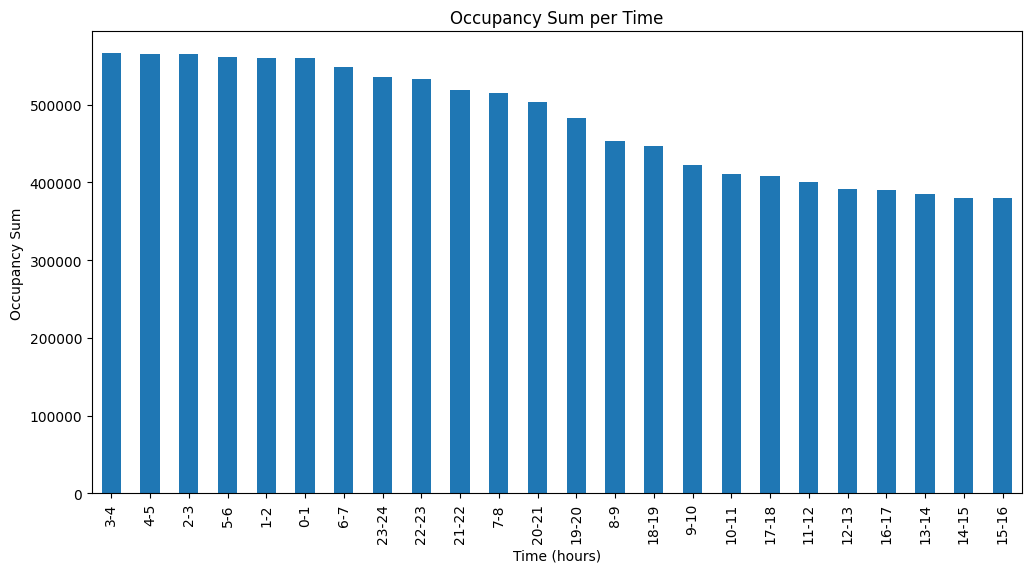

In [ ]:
import matplotlib.pyplot as plt

# Group the melted_df by 'time' and sum the occupancy
time_grouped = melted_df.groupby('time')['occupancy_sum'].sum()

# Sort the group in descending order
time_grouped_sorted = time_grouped.sort_values(ascending=False)

# Create a bar plot
time_grouped_sorted.plot(kind='bar', figsize=(12, 6))

# Set the plot title and axis labels
plt.title('Occupancy Sum per Time')
plt.xlabel('Time (hours)')
plt.ylabel('Occupancy Sum')

# Display the plot
plt.show()

In [ ]:
# Group the DataFrame by the 'zipcode' column and sum the occupancies
peak_effective_df = df_session_updated.groupby('zipcode')[[f"effective_charging_hrs{i}-{i+1}" for i in range(24)]].sum()

# Reset the index to flatten the DataFrame
peak_effective_df.reset_index(inplace=True)

# Melt the DataFrame to reshape it
melted_effective_df = peak_effective_df.melt(id_vars='zipcode', var_name='time', value_name='effective_sum')

# Print the melted DataFrame
print(melted_effective_df)


       zipcode                         time  effective_sum
0      1011 AC    effective_charging_hrs0-1     224.937319
1      1011 BG    effective_charging_hrs0-1     116.249638
2      1011 CB    effective_charging_hrs0-1     206.300000
3      1011 EG    effective_charging_hrs0-1     256.816667
4      1011 GT    effective_charging_hrs0-1     227.516667
...        ...                          ...            ...
59875  1384 AJ  effective_charging_hrs23-24     111.219928
59876  1384 AK  effective_charging_hrs23-24     156.078986
59877  1384 AL  effective_charging_hrs23-24      45.590761
59878  1384 AM  effective_charging_hrs23-24      38.263043
59879  3114 VP  effective_charging_hrs23-24      39.097283

[59880 rows x 3 columns]


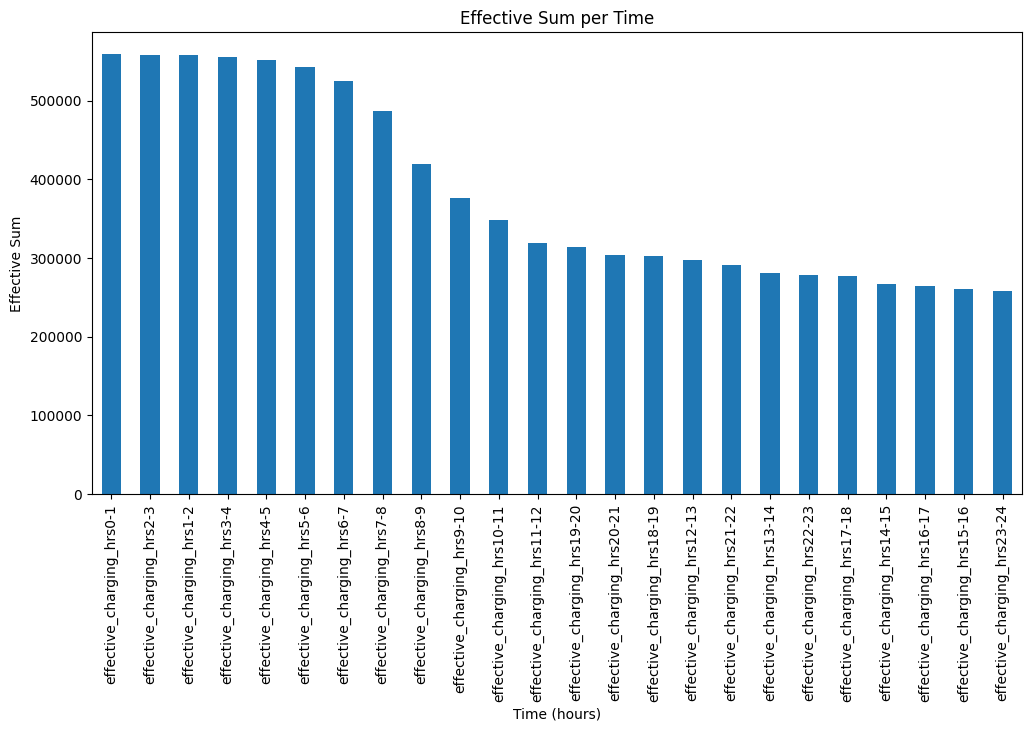

In [ ]:
# Group the melted_df by 'time' and sum the occupancy
time_grouped_eff = melted_effective_df.groupby('time')['effective_sum'].sum()

# Sort the group in descending order
time_grouped_eff_sorted = time_grouped_eff.sort_values(ascending=False)

# Create a bar plot
time_grouped_eff_sorted.plot(kind='bar', figsize=(12, 6))

# Set the plot title and axis labels
plt.title('Effective Sum per Time')
plt.xlabel('Time (hours)')
plt.ylabel('Effective Sum')

# Display the plot
plt.show()

In the next step we are setting up our KPIs for the model. Therefore, we first declare a maximum occupancy in hrs of 24 for each socket on each day. Then to calculate the max power we are multiplying the "power" by 24. This is the amount of kWh that the socket can potentially provide in one day. Our first KPI, the **blocked kWh** shows how much of the max power was blocked by a charger on a certain day. From this we can derive the **spare capacity in kWh**, taking the **effective charging** into account. However, the effective charging tells us only how long a car was charging. The spare capacity might be high because most of the times after being charged the car is still parked at the charger. Another approach is to display the **spare capacity in kWh** by taking the **occupany** into account. The amount of kWh that was used in a day does not display the truth but the capacity that is left does. The last version of the sparce capacity is the **spare capacity in hours**, showing *how much time was still left* on that day. 

In [ ]:
# add max occupancy
grouped_df['MaxOccupancy'] = 24

# add max power
grouped_df['MaxPower'] = grouped_df['MaxOccupancy'] * grouped_df['power']

# add blocked kwh 
grouped_df['Blocked_kWh'] = grouped_df['power'] * grouped_df['ConnectionTimeHours']

# add spare capacity in kwh regarding effective charging
grouped_df['SpareCap_Effective'] = grouped_df['MaxPower'] - grouped_df['kWh']

# add spare capacity in kwh regarding occupancy
grouped_df['SpareCap_Occup_kWh'] = grouped_df['MaxPower'] - grouped_df['power'] * grouped_df['ConnectionTimeHours']

# add spare capacity in h regarding occupancy 
grouped_df['SpareCap_Hrs'] = grouped_df['MaxOccupancy'] - grouped_df['ConnectionTimeHours']

# add % effective charging
grouped_df['Effective%'] = grouped_df['kWh'] / grouped_df['MaxPower']

# add % occupancy kwh
grouped_df['Occupancy_kwh%'] = (grouped_df['power'] * grouped_df['ConnectionTimeHours']) / grouped_df['MaxPower']

# add % occupancy h 
grouped_df['Occupancy_h%'] = grouped_df['ConnectionTimeHours'] / grouped_df['MaxOccupancy'] 

# add country for power BI visualization
grouped_df['Country'] = 'Netherlands'

In [ ]:
grouped_df

,ChargeSocket_ID,Date,Transaction_ID,Provider,City,Address,District,ChargePoint_ID,Socket_ID,IsFastCharger,...,MaxOccupancy,MaxPower,Blocked_kWh,SpareCap_Effective,SpareCap_Occup_kWh,SpareCap_Hrs,Effective%,Occupancy_kwh%,Occupancy_h%,Country
0,1000022923_1,2022-07-01,2,EQUANS,Amsterdam,Voornsestraat 7,Oost,1000022923,1,False,...,24,264.96,66.7920,194.950,198.1680,17.95,0.264229,0.252083,0.252083,Netherlands
1,1000022923_1,2022-07-02,4,EQUANS,Amsterdam,Voornsestraat 7,Oost,1000022923,1,False,...,24,264.96,182.3808,236.280,82.5792,7.48,0.108243,0.688333,0.688333,Netherlands
2,1000022923_1,2022-07-03,2,EQUANS,Amsterdam,Voornsestraat 7,Oost,1000022923,1,False,...,24,264.96,137.5584,229.380,127.4016,11.54,0.134284,0.519167,0.519167,Netherlands
3,1000022923_1,2022-07-04,3,EQUANS,Amsterdam,Voornsestraat 7,Oost,1000022923,1,False,...,24,264.96,145.7280,225.290,119.2320,10.80,0.149721,0.550000,0.550000,Netherlands
4,1000022923_1,2022-07-05,2,EQUANS,Amsterdam,Voornsestraat 7,Oost,1000022923,1,False,...,24,264.96,101.6784,259.200,163.2816,14.79,0.021739,0.383750,0.383750,Netherlands
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
863309,TOTAL*NN001858*015_3,2022-10-22,1,TOTAL,Amsterdam,Vorticellaweg 2,Noord,TOTAL*NN001858*015,3,False,...,24,176.64,2.4288,176.640,174.2112,23.67,0.000000,0.013750,0.013750,Netherlands
863310,TOTAL*NN001858*015_3,2022-10-24,2,TOTAL,Amsterdam,Vorticellaweg 2,Noord,TOTAL*NN001858*015,3,False,...,24,176.64,11.7760,120.849,164.8640,22.40,0.315846,0.066667,0.066667,Netherlands
863311,TOTAL*NN001858*015_3,2022-10-26,1,TOTAL,Amsterdam,Vorticellaweg 2,Noord,TOTAL*NN001858*015,3,False,...,24,176.64,3.7536,164.085,172.8864,23.49,0.071077,0.021250,0.021250,Netherlands
863312,TOTAL*NN001858*015_3,2022-10-29,1,TOTAL,Amsterdam,Vorticellaweg 2,Noord,TOTAL*NN001858*015,3,False,...,24,176.64,1.9136,168.223,174.7264,23.74,0.047651,0.010833,0.010833,Netherlands


In [ ]:
# saving DF to google drive
grouped_df.to_csv('/content/drive/My Drive/grouped_df_2022_1.csv', index=False)

The next aggregation will be on charger level. This is the actual aggregation we furhter want to continure with. 

In [ ]:
# group the data frame by ChargePoint_ID and Date
# caution, we still use the power per socket as we are summing up the hours used;
# if we would both increase the hours and the kwh it would not match the socket data 
# anymore
grouped_df_charger = df_session_updated.groupby(['ChargePoint_ID', 'Date']).agg({
    'Transaction_ID': 'count',
    'Provider': 'first',
    'City': 'first',
    'Address': 'first',
    'District': 'first',
    'IsFastCharger': 'first',
    'IsAppPayment': 'first',
    'ConnectionTimeHours': 'sum',
    'kWh': 'sum',
    'Total': 'first',
    'Vattenfall': 'first',
    'Allego': 'first',
    'Equans': 'first',
    'EvBox': 'first',
    'Nuon': 'first',
    'WDS': 'first',
    'Engie': 'first', 
    'Pitpoint': 'first',
    'Ecotap': 'first',
    'ChargeSocket_ID_count': 'first',
    'power': 'mean',  
    'zipcode': 'first',
    'effective_charging_hrs': 'sum',
    **{f"{i}-{i+1}": 'sum' for i in range(24)},
    **{f"effective_charging_hrs{i}-{i+1}": 'sum' for i in range(24)}
})

# Reset the index to flatten the DataFrame
grouped_df_charger.reset_index(inplace=True)

In [ ]:
# add max occupancy; here we need to pay attention how many sockets a chargers has
grouped_df_charger['MaxOccupancy'] = grouped_df_charger['ChargeSocket_ID_count'].apply(lambda count: 24 * count)

# add max power
grouped_df_charger['MaxPower'] = grouped_df_charger['MaxOccupancy'] * grouped_df_charger['power']

# add blocked kwh 
grouped_df_charger['Blocked_kWh'] = grouped_df_charger['power'] * grouped_df_charger['ConnectionTimeHours']

# add spare capacity in kwh regarding effective charging
grouped_df_charger['SpareCap_Effective'] = grouped_df_charger['MaxPower'] - grouped_df_charger['kWh']

# add spare capacity in kwh regarding occupancy
grouped_df_charger['SpareCap_Occup_kWh'] = grouped_df_charger['MaxPower'] - (grouped_df_charger['power'] * grouped_df_charger['ConnectionTimeHours'])

# add spare capacity in h regarding occupancy 
grouped_df_charger['SpareCap_Hrs'] = grouped_df_charger['MaxOccupancy'] - grouped_df_charger['ConnectionTimeHours']

# add % effective charging
grouped_df_charger['Effective%'] = grouped_df_charger['kWh'] / grouped_df_charger['MaxPower']

# add % occupancy kwh
grouped_df_charger['Occupancy_kwh%'] = (grouped_df_charger['power'] * grouped_df_charger['ConnectionTimeHours']) / grouped_df_charger['MaxPower']

# add % occupancy h 
grouped_df_charger['Occupancy_h%'] = grouped_df_charger['ConnectionTimeHours'] / grouped_df_charger['MaxOccupancy'] 

# add country for power BI visualization
grouped_df_charger['Country'] = 'Netherlands'

In [ ]:
# saving DF to google drive
grouped_df_charger.to_csv('/content/drive/My Drive/grouped_df_charger_2023.csv', index=False)

In [ ]:
# saving grouped dfs by zipcode
melted_df.to_csv('/content/drive/My Drive/melted_df_2023.csv', index=False)

melted_effective_df.to_csv('/content/drive/My Drive/melted_df_eff_2023.csv', index=False)

As a next step we retrieve again all the data frames that we have saved on google drive and merge them into one. As mentioned in the beginning, in the end we only merge part 1 of 2022, part 2 of 2022 and the first quarter of 2023. 

In [ ]:
# merging all the years
import pandas as pd

file_path_2022a = '/content/drive/My Drive/grouped_df_charger_2022.csv'
df_session_2022a = pd.read_csv(file_path_2022a)

file_path_2022b = '/content/drive/My Drive/grouped_df_charger_2022_1.csv'
df_session_2022b = pd.read_csv(file_path_2022b)

file_path_2023 = '/content/drive/My Drive/grouped_df_charger.csv'
df_session_2023 = pd.read_csv(file_path_2023)

# file_path_2021 = '/content/drive/My Drive/grouped_df_charger_2021.csv'
# df_session_2021 = pd.read_csv(file_path_2021)

# file_path_2020 = '/content/drive/My Drive/grouped_df_charger_2020.csv'
# df_session_2020 = pd.read_csv(file_path_2021)

# file_path_2019 = '/content/drive/My Drive/grouped_df_charger_2019.csv'
# df_session_2019 = pd.read_csv(file_path_2019)

# merge them 
# frames = [df_session_2019, df_session_2020, df_session_2021, df_session_2022a, df_session_2022b, df_session_2023]
# df_all = pd.concat(frames)

# merge 2022 - 2023
frames_23 = [df_session_2022a, df_session_2022b, df_session_2023]
df_23 = pd.concat(frames_23)

# saving DF to google drive
df_23.to_csv('/content/drive/My Drive/df_charger_22_23.csv', index=False)

As a last step we want to further aggregate on a zipcode, weekly level.
Caution: This happens now in separate Google Colab file ("weekly_aggregation.ipynb").